# CH3. Statistial Experiments and Significance Testing

**통계적 실험과 유의성검정**

**3.6 다중검정**

**3.7 자유도**

**3.8 ANOVA(분산분석)**



# data import and library load

In [1]:
# 라이브러리 불러오기

%matplotlib inline

from pathlib import Path
import random

import pandas as pd
import numpy as np
from scipy.stats import trim_mean
from scipy import stats
from sklearn.utils import resample
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import power

import seaborn as sns
import matplotlib.pylab as plt

import time

In [2]:
try:
    import common
    DATA = common.dataDirectory()
except ImportError:
    DATA = Path().resolve() / 'data'

In [3]:
# WEB_PAGE_DATA_CSV = DATA / 'web_page_data.csv'
FOUR_SESSIONS_CSV = DATA / 'four_sessions.csv'
CLICK_RATE_CSV = DATA / 'click_rates.csv'
IMANISHI_CSV = DATA / 'imanishi_data.csv'

# 다중검정
---
3.6 

데이터에 대해서 다양한 관점으로 충분한 질문을 던지다 보면 대부분 통계적으로 유의미한 결과가 나오게 된다.

이떄 어떤 효과가 통계적으로 유믜이마하다고 '잘못'된 결론을 내리는 경우를 **제1종 오류**라고 하는데, 0.05의 유의수준에서 항항 유의미하지 않다는 올바른 검정 결과가 나올 확률을 먼저 계산한 다음 1에서 빼면 이 확률을 구할 수 있다. 무의미하다고 정확하게 검정을 할 확률이 0.95이므로, 20번의 유의성 검정을 수행한다면 하면 $ 0.95^{20} = 0.36$ 이다. 

즉, 적어도 하나의 예측값이 유의미하다고 검정 결과가 나올 확률은 이 확률의 나머지, $ 1- (모든 것이 무의미하다는 결론이 나올 확률) = 0.64$ 가 된다.

이것을 **알파 인플레이션**이라고 한다.

이 문제는 데이터 마이닝에서 오버피팅 관련 문제가 있다. 

추가하는 변수가 많을 수록 또는 더 많은 모델을 사용할 수록 뭔가가 우연에 의해 '유의미한 것'으로 나타날 확률이 커진다.

##### 용어 정리

> 제1종 오류(type 1 error): 어떤 효과가 통계적으로 유의미하다고 잘못된 결론을 내린 것

> 거짓 발견 비율(FDR, False, Discovery Rate): 다중검정에서 1종 오류가 발생하는 비율. 레코드가 1로 표시된 것이 거짓일 확률

> 알파 인플레이션(alpha inflation): 제1종 오류를 만들 확률인 **알파**가 더 많은 테스트를 수행할 수록 증가하는 다중검정 현상

> p값 조정(adjustment of p-value): 동일한 데이터에 대해 다중검정을 수행하는 경우에 필요

> 과대적합(overffiting): 잡음까지 피팅


통계학에서 수정 절차는 보통, 단일 가설검정을 할 때보다 통계적 유의성에 대한 기준을 더 엄격하게 설정함으로서 보완한다.

일반적으로 검정 횟수에 따라 '유의 수준을 나누는' 방법을 사용한다. 

이는 각 검정에 대해 더 작은 알파를(0.05에서 0.01을 적용한다던가?), 즉 통계쩍 유의성에 대해 더 엄격한 잣대를 적용한다.

> 본페로니 수정(Bonferroni adjustment): 알파를 비교 횟수n 으로 나눔

> 투키의 HSD(투키의 정직유의차, honest significant difference): 그룹 평균 간의 최대 차이에 적용하는 방법. 순열검정처럼 모든 값을 섞고 그룹과 동일한 크기의 재표본 그룹을 뽑아서 재표본한 그룹 평균 간의 최대 차이에 적용.

---

다중검정문제는 데이터를 고문하듯 샅샅이 훑는 것과 관련이 있다. **달리 말하면 충분히 복잡한 데이터가 주어졌을 때 흥미로운 것을 발견하지 못했다면 데이터를 충분히 들여다보지 않은 탓이다.**

# 자유도
---
3.7

'자유도' : 표본 데이터에서 계산된 통계량에서, 변화가 가능한 값들의 개수. d.f.(degree of freedom)이라고도 부른다.

n이 충분히 크게 되면 거의 차이가 없다. 하지만 회귀에서 요인 변수를 사용할 때, 범주형 변수를 이진 지표로 변 요인화 할 때 많이 일어난다.

다중공산성 문제를 피하기 위해 범주형 변수들을 n-1 지표나 더미 변수로 요인화하는 것의 이유가 된다.

# 분산분석: ANOVA
---
3.6.ANOVA

여러 그룹 간의 결과를 분석하기 위해, 통계적으로 유의미한 차이를 검정하는 통계적 절차.

AB검정과 비슷한 절차를 확장하여, 그룹 간 전체적인 평차가 우연히 발생할 수 있는 범위 내에 있는지를 평가하기 위해 사용한다.

ANOVA 결과의 유용함은 그룹 처리, 상호작용 효과, 오차와 관련된 분산의 구성 요소들을 구분하는 데에 있다.

##### 용어정리

> 쌍별 비교(pairwise comparison): ㅇ여러 그룹 중 두 그룹 간의(ex. 평균에 대한) 가설검정

> 총괄검정(omnibus test): 여러 그룹 평균들의 전체 분산에 관한 단일 가설 검정

> 분산분해(decomposition of variance): 구성 요소 분리. 예를 들면, 전체 평균, 처리 평균, 잔차 오차로 부터 개별 값들에 대한 기여를 뜻한다.

> F-통계량(F-statistic): 그룹 평균 간의 차이가 **랜덤 모델에서 예상되는 것에서 벗어나는 정도** 를 측정하는 표준화된 통계량

> SS(sum of squares): 어떤 평균으로부터의 편차들의 제곱을 합한 것

##  four_sessions

네 페이지의 세션 시간 비교검정하기

In [4]:
four_sessions = pd.read_csv(FOUR_SESSIONS_CSV)

In [5]:
four_sessions.head()

,Page,Time
0,Page 1,164
1,Page 2,178
2,Page 3,175
3,Page 4,155
4,Page 1,172


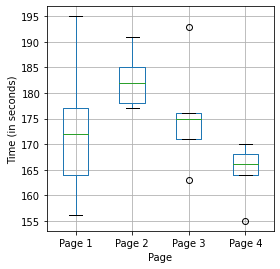

In [6]:
# 박스플롯으로 바로 시각화 하기

ax = four_sessions.boxplot(by = 'Page', column = 'Time',
                           figsize=(4, 4))
ax.set_xlabel('Page')
ax.set_ylabel('Time (in seconds)')
plt.suptitle('')
plt.title('')

plt.tight_layout()
plt.show()

### 결과 및 원본 코드 

서로 차이가 큰 것을 볼 수 있는데, 한 쌍씩 비교하는 횟수가 증가할 수록 우연히 일어난 일에 속을 가능성이 커진다.

개별간의 비교에 대해 걱정하는 대신, '모든 페이지가 동일한 점착성을 갖는지, 이들 차이는 우연이고 원래 4 페이지에 할당된 세션 시간 역시 무작위가 맞는지,' 라는 질문을 다루는 총괄검정을 할 수 있다. 이때 사용하는 것이 ANOVA인 것이다!

In [ ]:
# original code 

# four_sessions = pd.read_csv(FOUR_SESSIONS_CSV)

# ax = four_sessions.boxplot(by='Page', column='Time',
#                            figsize=(4, 4))
# ax.set_xlabel('Page')
# ax.set_ylabel('Time (in seconds)')
# plt.suptitle('')
# plt.title('')

# plt.tight_layout()
# plt.show()

## ANOVA의 토대가 되는 재표본 추출 과정

1. 모든 데이터를 한 곳에 모음
2. 5개의 값(각 페이지별 레코드 수) 을 갖는 4개의 재표본(페이지 개수)을 섞어서 추출
3. 각 재표본 그룹의 평균을 기록
4. 네 그룹 평균 사이의 분산을 기록
5. 위 2-4단계를 반복

재표본추출한 분산이 관찰된 변화를 초과한 시간은 바로 p값이 된다.

이전에 했었던 순열검정을 다시 해본다.

In [10]:
# 원래의 각 그룹별 평균의 분산
observed_variance = four_sessions.groupby('Page').mean().var()[0] 

# 원래 그룹별 평균과 분산 출력해두기
print('Observed means: ', four_sessions.groupby('Page').mean().values.ravel())
print('Variance: ', observed_variance)

# df 내의 값들을 섞는 함수
def perm_test(df):
    df = df.copy()                                        # 원본을 바꾸지 않도록
    df['Time'] = np.random.permutation(df['Time'].values) # Time 레코드를 랜덤하게 순서를 바꿈
    return df.groupby('Page').mean().var()[0]             # TIme 레코드만 바뀌어있기에 랜덤하게 바뀐 값들을 Page별로 그룹해서 평균의 분산을 구함

# 3000 번 반복
perm_variance = [perm_test(four_sessions) for _ in range(3000)] # R번 반복한 평균의 분산들
print('Pr(Prob)', np.mean([var > observed_variance for var in perm_variance])) # R개의 분산들 중 원래의 평균의 분산을 넘어가는 애들의 

Observed means:  [172.8 182.6 175.6 164.6]
Variance:  55.426666666666655
Pr(Prob) 0.08266666666666667


### 결과 및 원본 코드

통상적인 임계값 5%에 달하지 못하고 8퍼센트이다. 그렇기에 네 페이지 간의 차이가 우연히 발생할 수 있다고 결론 내리게 된다.

In [ ]:
# # original code

# observed_variance = four_sessions.groupby('Page').mean().var()[0]
# print('Observed means:', four_sessions.groupby('Page').mean().values.ravel())
# print('Variance:', observed_variance)
# # Permutation test example with stickiness
# def perm_test(df):
#     df = df.copy()
#     df['Time'] = np.random.permutation(df['Time'].values)
#     return df.groupby('Page').mean().var()[0]
    
# print(perm_test(four_sessions))

## F통계량

두 그룹의 평균을 비교하기 위해 순열겁정 대신 t검정을 사용할 수 있듯,

F통계량을 기반으로한 ANOVA검정도 있다. F통계량은 잔차 오차로 인한 분산과 그룹 평균(처리 효과)의 분산에 대한 비율을 기초로 한다.

이 비율이 높을수록 통계적으로 유의미하다고 할 수 있다. 

데이터가 정규분포를 따를 경우, 통계 이론에 따르면 해당 통계량은 특정 분포를 따르게 되어있는데, 이를 토대로 p값을 계산할 수 있다.

구하기 위해 statsmodel을 사용한다!

In [11]:
# import statsmodels.api as sm
# import statsmodels.formula.api as smf

f_model = smf.ols('Time ~ Page', data = four_sessions).fit()

In [13]:
# analysis of variance aov
aov_table = sm.stats.anova_lm(f_model)
aov_table

,df,sum_sq,mean_sq,F,PR(>F)
Page,3.0,831.4,277.133333,2.739825,0.077586
Residual,16.0,1618.4,101.150000,NaN,NaN


### 결과 및 원본 코드

Df는 자유도, sum_sq 는 제곱합, mean_sq는 평균제곱편차, F는 F통계량을 가르킨다.

(여기는 정말 이해가 안가는 부분인데)

총평균의 경우, 제곱합은 0에서부터 총평균까지의 거리를 구하고, 제곱한 다음, 20(관측수)를 곱한 값과 같다. 따라서 총평균에 대한 자유도는 정의에 따라 1이 된다.

처리 방법에 대한 평균의 자유도는 3이다. (3개의 평균과 함께 총평균이 정해지면 나머지 평균은 달라질 수없다. 는 알겠다) 처리 평균에 대한 제곱합은 각 처리 평균과 총평균 사이의 편차를 제곱한 값들의 합이다.

잔차의 경우 자유도는 16(즉 20개 관측값 중에 16개는 총평균과 처리 평균이 정해지면 달라질 수 있음)이며

SS는 개별 관측치와 처리 평균의 차의 제곱합이가. 평균 제곱(MS)는 제곱합을 자유도로 나눈 값이다.

F통계량은 MS(처리)/MS(오차). F값은 이 비율에 따라 결정되며 표준 F분포와 비교하여 그룹 평균간의 차이가 랜덥 변이에서 예상되는 것보다 큰지 여부를 결정할 수 있다.



## 이원 분산분석

비교해야할 요소가 두 가지일 때. 지금 데이터라고 친다면 평일 주말 이렇게 한 번 더 나뉜다던지 하는 부분이다. 이때 필요한 것이 이원 ANOVA.

상호작용 효과를 확인하는 식으로, 일원 ANOVA와 방식은 비슷하다.

이때 총평균 효과와 처리 효과를 확인한 후, 각 그룹의 주말과 평일 데이터를 따로 분리한다. 그리고 그 부분집합들에 대한 평균과 처리 평균 사이의 차이를 찾는다. 

회귀와 로지스틱 회귀 같은 모델을 위해 이원 ANOVA분석이 사용된다.

